<a href="https://colab.research.google.com/github/kaspar0852/Text-to-image-CLIP-and-Taming-transformer/blob/main/Text_To_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/openai/CLIP.git
!git clone https://github.com/CompVis/taming-transformers

Cloning into 'CLIP'...
remote: Enumerating objects: 236, done.
remote: Total 236 (delta 0), reused 0 (delta 0), pack-reused 236
Receiving objects: 100% (236/236), 8.92 MiB | 37.12 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1339, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1339 (delta 0), reused 2 (delta 0), pack-reused 1335
Receiving objects: 100% (1339/1339), 409.77 MiB | 38.35 MiB/s, done.
Resolving deltas: 100% (278/278), done.


In [2]:
## install some libraries
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 561 kB 30.9 MB/s 
     |████████████████████████████████| 829 kB 68.8 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491071 sha256=3a23491aeb76529f2ed0b5907b9dea6c6fccae0a2ee06f67390fac14bc64299b
  Stored in directory: /root/.cache/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfully built future
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
Found existing installation: torchtext 0.14.0
Uninstalling torchtext-0.14.0:
  Successfully uninstalled torchtext-0.14.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.de

In [3]:
#import libraries
import numpy as np
import torch,os,imageio,pdb,math
import torchvision 
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL 
import matplotlib.pyplot as plt

import yaml
from omegaconf import OmegaConf

from CLIP import clip

#import warnings
#warnings.filterwarning('ignore')

In [4]:
##helper functions

def show_from_tensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1,2,0))

  plt.figure(figsize = (10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

  #this function will take tensor and display it as an image

def norm_data(data):
   #it will receive the data and normalize it in a follwoing way
   return(data.clip(-1,1)+1)/2 ##we are going to move in between 0 to 1 in result

##Parameters and Hyperparameters
learning_rate = .5
batch_size = 1
wd = .1 #weight decay is a regulizer paramerter that is going to help the optimizer limit the size-
#-of weights to improve the generalization capabilities of the architecture
noise_factor = .1 

total_iter = 100 #increace this for more refined results
#as we take a text prompt and we begin to generate the image,then there will be comparison of encoding of text prompt-
#-with the enoding of the image we are generating and we calculate the loss suing the Cosine Similarity-
#-mathematical function applied to the result of those encodings

im_shape = [225,400,3] #height,width ,channel
size1, size2,channels = im_shape


In [5]:
#Setting up the CLIP model
clipmodel, _ = clip.load('ViT-B/32',jit = False)
clipmodel.eval()
print(clip.available_models())

print('Clip model visual input resolution:',clipmodel.visual.input_resolution)

device = torch.device("cuda:0")
torch.cuda.empty_cache()
#We can proceed to use clip in inferrence, eval mode to encode texts and images directly

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 192MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution: 224


In [6]:
## Taming transformer instantiation

%cd taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
   !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt' 
   !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml' 


/content/taming-transformers
--2023-01-02 06:30:13--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/4744e31a-3fd5-4b17-bdbc-f84dfa50e56c/last.ckpt [following]
--2023-01-02 06:30:13--  https://heibox.uni-heidelberg.de/seafhttp/files/4744e31a-3fd5-4b17-bdbc-f84dfa50e56c/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  14.2MB/s    in 63s     

2023-01-02 06:31:16 (15.0 MB/s) - ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ saved [980092370/980

In [7]:
from taming.models.vqgan import VQModel

#we need a couple of helper functions
def load_config(config_path,display = False):
  config_data = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config_data)))
  return config_data

def load_vqgan(config,chk_path = None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location ="cpu")["state_dict"]
    missing,unexpected = model.load_state_dict(state_dict,strict = False)
  return model.eval()

def generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x 
  #when we generate something from this model,it has to go through two stages-
  #-1 is the convolutional network and 2nd actual decoder of the transformer

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml",display = True)
taming_model = load_vqgan(taming_config,chk_path = "./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 494kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [8]:
#we are seeing all the detailed information of the generator /transformer model when we execute the -
#-top code it uses 256 channels,and patches of 16 * 16 pixels each

In [12]:
##Declare the values that we are going to optimize
#These are the values that we are going to gradually changing-
#-and optimizing to produce image that matches the text prompt.
class Parameters(torch.nn.Module):
  def __init__(self):
    super(Parameters, self).__init__()
    self.data = .5*torch.randn(batch_size, 256, size1//16, size2//16).cuda() # 1x256x14x15 (225/16, 400/16)
    self.data = torch.nn.Parameter(torch.sin(self.data))

  def forward(self):
    return self.data

def init_params():
  params=Parameters().cuda()
  optimizer = torch.optim.AdamW([{'params':[params.data], 'lr': learning_rate}], weight_decay=wd)
  return params, optimizer



torch.Size([1, 256, 14, 25])
img dimensions:  torch.Size([1, 3, 224, 400])


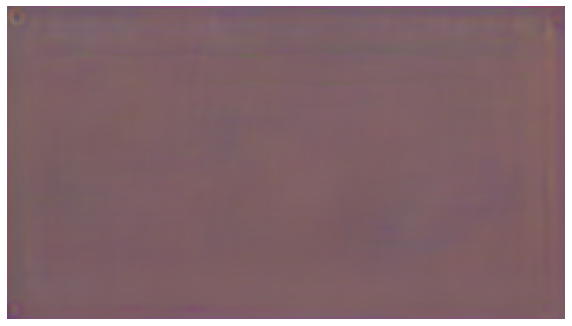

In [13]:
#here we will implement functions which will use the CLIP architecture to encode the text prompts
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encodeText(text):
  t=clip.tokenize(text).cuda()
  t=clipmodel.encode_text(t).detach().clone()
  return t

def createEncodings(include, exclude, extras):
  include_enc=[]
  for text in include:
    include_enc.append(encodeText(text))
  exclude_enc=encodeText(exclude) if exclude != '' else 0
  extras_enc=encodeText(extras) if extras !='' else 0

  return include_enc, exclude_enc, extras_enc
#another very important thing we need to decalre which we will be using later is that,-
#-we are going to be creating the crops of the image
augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2), fill=0)  
).cuda()

Params, optimizer = init_params()

with torch.no_grad():
  print(Params().shape)
  img= norm_data(generator(Params()).cpu()) # 1 x 3 x 224 x 400 [225 x 400]
  print("img dimensions: ",img.shape)
  show_from_tensor(img[0])

In [14]:
# create crops
#because when we want to generate the image we want to send the crops-
#–of the image to the CLIP architecture with some augmentations,rotations-
#-,translations so that we give variation of images to CLIP and we help 
#–clip to undertstand the image better so that it can match the text encodings

def create_crops(img, num_crops=32): 
  p=size1//2
  img = torch.nn.functional.pad(img, (p,p,p,p), mode='constant', value=0) # 1 x 3 x 448 x 624 (adding 112*2 on all sides to 224x400)

  img = augTransform(img) #RandomHorizontalFlip and RandomAffine

  crop_set = []
  for ch in range(num_crops):
    gap1= int(torch.normal(1.2, .3, ()).clip(.43, 1.9) * size1)
    offsetx = torch.randint(0, int(size1*2-gap1),())
    offsety = torch.randint(0, int(size1*2-gap1),())

    crop=img[:,:,offsetx:offsetx+gap1, offsety:offsety+gap1]

    crop = torch.nn.functional.interpolate(crop,(224,224), mode='bilinear', align_corners=True)
    crop_set.append(crop)

  img_crops=torch.cat(crop_set,0) ## 30 x 3 x 224 x 224

  randnormal = torch.randn_like(img_crops, requires_grad=False)
  num_rands=0
  randstotal=torch.rand((img_crops.shape[0],1,1,1)).cuda() #32
  
  for ns in range(num_rands):
    randstotal*=torch.rand((img_crops.shape[0],1,1,1)).cuda()

  img_crops = img_crops + noise_factor*randstotal*randnormal

  return img_crops

In [15]:
#Defining a function to show current stage of Generation
def showme(Params, show_crop):
  with torch.no_grad():
    generated = generator(Params())

    if (show_crop):
      print("Augmented cropped example")
      aug_gen = generated.float() # 1 x 3 x 224 x 400 
      aug_gen = create_crops(aug_gen, num_crops=1)
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print("Generation")
    latest_gen=norm_data(generated.cpu()) # 1 x 3 x 224 x 400
    show_from_tensor(latest_gen[0])

  return (latest_gen[0]) 

In [16]:
#Optimization process
def optimize_result(Params, prompt):
  alpha=1 ## the importance of the include encodings
  beta=.5 ## the importance of the exclude encodings

  ## image encoding
  out = generator(Params())
  out = norm_data(out)
  out = create_crops(out)
  out = normalize(out) # 30 x 3 x 224 x 224
  image_enc=clipmodel.encode_image(out) ## 30 x 512

  ## text encoding  w1 and w2
  final_enc = w1*prompt + w1*extras_enc # prompt and extras_enc : 1 x 512
  final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True) # 1 x 512
  final_text_exclude_enc = exclude_enc

  ## calculate the loss
  main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1) # 30
  penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1) # 30

  final_loss = -alpha*main_loss + beta*penalize_loss

  return final_loss

def optimize(Params, optimizer, prompt):
  loss = optimize_result(Params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
#The training loop
def training_loop(Params, optimizer, show_crop=False):
  res_img=[]
  res_z=[]

  for prompt in include_enc:
    iteration=0
    Params, optimizer = init_params() # 1 x 256 x 14 x 25 (225/16, 400/16)

    for it in range(total_iter):
      loss = optimize(Params, optimizer, prompt)

      if iteration>=80 and iteration%show_step == 0:
        new_img = showme(Params, show_crop)
        res_img.append(new_img)
        res_z.append(Params()) # 1 x 256 x 14 x 25
        print("loss:", loss.item(), "\niteration:",iteration)

      iteration+=1
    torch.cuda.empty_cache()
  return res_img, res_z